<a href="https://colab.research.google.com/github/winterForestStump/tutorial-env/blob/main/SocialMediaAnalytics/SMA_portfolioexam_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News classification project

Project Scenario: Fake News Detection Using EUvsDisinfo Database

Goal and Purpose: The goal of this project is to develop a text classifier for the detection of fake news using the EUvsDisinfo database. The EUvsDisinfo project is dedicated to identifying and exposing disinformation cases originating from pro-Kremlin outlets. By utilizing this database, the project aims to create a system that can classify news articles as either genuine or fake, helping users discern the credibility of information they encounter.

Data: The project utilizes the EUvsDisinfo database, which is a comprehensive collection of disinformation cases and their corresponding disproofs. The database is continually updated on a weekly basis, ensuring that the classifier remains up to date with the latest disinformation trends. The data includes information from various languages, as the disinformation cases monitored by EUvsDisinfo may originate from different sources worldwide.

Data source: https://euvsdisinfo.eu/disinformation-cases/

Web Scraping: To retrieve data from the EUvsDisinfo website, the project employs a web scraping code written in Python, as indicated by the `webscraping_code.ipynb` file. This code automatically extracts the relevant information from the website, allowing the project to access the disinformation cases stored in the EUvsDisinfo database.

More information about the EUvsDisinfo project: https://euvsdisinfo.eu/to-challenge-russias-ongoing-disinformation-campaigns-the-story-of-euvsdisinfo/

Plan: The project follows a multi-step plan to develop the fake news detection system:

1) Data Analysis: The collected data from the EUvsDisinfo database is analyzed to gain insights into the characteristics  of fake news.

2) Doc2Vec Method: The project employs the Doc2Vec method, a text representation technique, to convert the news articles into numerical vectors. Doc2Vec captures the semantic meaning of the text.

3) Transformer Model: For the text classification task, the project utilizes the Roberta transformer model. Transformer models, based on attention mechanisms, have proven to be effective in various natural language processing tasks. The Roberta model, a variant of the Transformer architecture, has demonstrated strong performance in text classification and understanding tasks.

By training the Roberta transformer model on the labeled data from the EUvsDisinfo database, the project aims to develop a classifier capable of identifying fake news articles accurately.

The resulting system can then be used by individuals, organizations, and platforms to automatically flag potential instances of fake news, promoting media literacy and helping users make more informed decisions about the information they consume.

Import required libraries and modules:

* The `transformers` package is a popular open-source library developed by Hugging Face. It provides a high-level API for natural language processing (NLP) tasks, particularly focused on pre-trained models for tasks like text classification, named entity recognition, machine translation, and more. The library also includes utilities for tokenization, model training, and inference.

* The `accelerate` package is also developed by Hugging Face and is designed to accelerate the training and inference of models from the transformers library. By using accelerate, you can train or run models more efficiently on multiple GPUs or distributed systems.

In [1]:
%%capture
!pip install transformers accelerate -U;

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec
import gensim.downloader

from nltk.tokenize import word_tokenize
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import torch
import transformers
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback
from transformers import AutoTokenizer, RobertaForSequenceClassification

In [3]:
from huggingface_hub import notebook_login
notebook_login()

## 1. Analysing data from EUVSDISINFO website

After webscapping data from the website we have 9965 rows with fake news or dissinformation and 9 columns:
* Date - the date of fake news release
* Title - the title of the fake news; headline which summarizes the message, indicating what the disinformation considered to be
* URL - web link to the news description
* Outlets - news agences from dissinformation originated
* Countries - countries mentioned in the fake news
* Language - the language of the fake news
* Summary - summary of the pro-Kremlin disinformation (fake news) translated into English; currently tha database covers over 20 languages
* Disproof - points made by "EU vs Disinfo" organization to disproof the disinformation (fake news) using publicly available official documents and statements, academic reports and studies, findings of fact-checkers and reporting of international media. Will be used as true news while training
* Keywords - keywords from the fake news

Read scrapped .csv file from github:

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/winterForestStump/projects/main/social_media_analytics/disinformation_database.csv')

Drop redundant column and null instancies from the 'Summary' and 'Disproof' columns

In [5]:
data = data.drop(columns=['Unnamed: 0'])
data.dropna(subset=['Summary', 'Disproof'], inplace=True)
data = data.astype(str)

In [6]:
print(data.shape)
data.head(1)

(9963, 9)


,Date,Title,URL,Outlets,Countries,Language,Summary,Disproof,Keywords
0,10.05.2023,USSR Victory Banner was raised over the Bundes...,https://euvsdisinfo.eu/report/ussr-victory-ban...,"ntv.ru,eadaily.com,Moskovskij Komsomolets,tsar...","Russia, ...",Russian,The Russians took Berlin without firing a shot...,The video is a manipulation. The Red Banner of...,World War 2


We have 9963 rows with fake news in 'Summary' column and 9963 rows with true news in 'Disproof' column. The texts from column 'Summary' are summaries of the fake news translated into English.

EUvsDisinfo highlights examples of disinformation messages unless the context clearly states that the claim is untrue. This e.g. means that clearly labelled satire does not included. Disinformation cases can, however, appear in the context of e.g. a televised talk show discussion where competing opinions are also made available: When the context of a clear disinformation message legitimises it as a relevant “opinion” – even if it is part of a “mix” of different points of view – project considers the case to be of relevance to reporting.

The EUvsDisinfo database includes “disproofs”, which explain the components that make a certain claim disinformation, i.e. verifiably false or misleading information that is created, presented and disseminated for economic gain or to intentionally deceive the public, and may cause public harm.

Data description:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9963 entries, 0 to 9964
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       9963 non-null   object
 1   Title      9963 non-null   object
 2   URL        9963 non-null   object
 3   Outlets    9963 non-null   object
 4   Countries  9963 non-null   object
 5   Language   9963 non-null   object
 6   Summary    9963 non-null   object
 7   Disproof   9963 non-null   object
 8   Keywords   9963 non-null   object
dtypes: object(9)
memory usage: 778.4+ KB


No missing data, all values are text objects

Plotting a time series of the fake news publishing frequencies

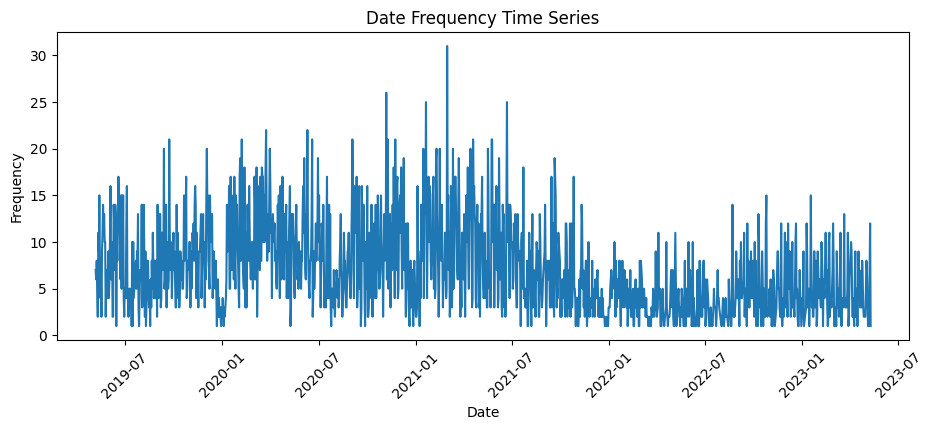

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
date_counts = data['Date'].value_counts().sort_index() #count the frequency of each date
fig, ax = plt.subplots(figsize=(11, 4))
plt.plot(date_counts.index, date_counts.values)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Date Frequency Time Series')
plt.xticks(rotation=45) #for better visibility
plt.show()

`Countries` column contains information about the countries in the articles:

In [9]:
data['Countries'] = data['Countries'].str.replace(r'\s+', ' ', regex=True)
data['Countries'].value_counts(normalize=True)*100

Ukraine, Russia                                         9.715949
Ukraine                                                 7.266887
Russia                                                  5.249423
US                                                      4.727492
US, Russia                                              3.131587
                                                          ...   
Belarus, Poland, Ukraine, Germany, Lithuania, Latvia    0.010037
Russia, Germany, UK                                     0.010037
Ukraine, Russia, France, Germany, EU                    0.010037
Russia, US, EU, Moldova, Belarus, Ukraine               0.010037
Iran, Germany                                           0.010037
Name: Countries, Length: 2175, dtype: float64

Some of the articles contain multiple country names. In order to calculate the distribution of fake news by country, we need to make some changes:

In [10]:
countries_df = pd.DataFrame(data['Countries'].str.split(',').tolist()).stack().reset_index(level=1, drop=True) #new DataFrame to store the individual countries
countries_df = countries_df.str.strip()
countries_df.value_counts(normalize=True).head(5)*100 #count the frequency of each country in %

Russia     24.139120
Ukraine    17.752015
US         14.726544
EU          5.981985
Poland      4.421842
dtype: float64

Top-5 the most popular countries (regions) in fake news articles are: Russia, Ukraine, US, EU, Poland

Top-15 regions from fake news:

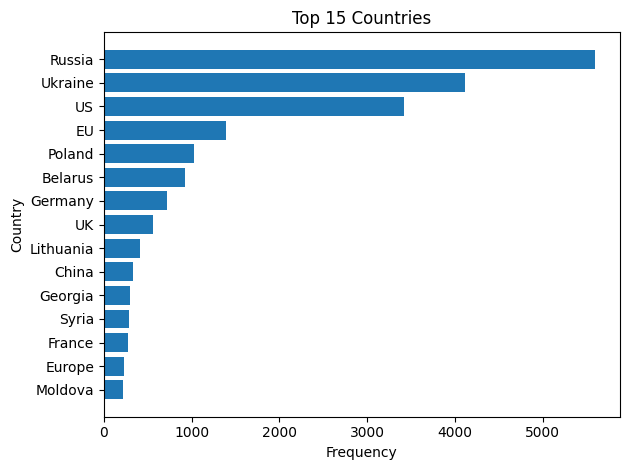

In [11]:
country_counts = countries_df.value_counts().head(15)
country_counts = country_counts.iloc[::-1]
plt.barh(country_counts.index, country_counts.values)
plt.xlabel('Frequency')
plt.ylabel('Country')
plt.title('Top 15 Countries')
plt.tight_layout()
plt.show()

Some articles are translated in English from foreign languages. We can look at the original languages of the fake articles:

In [12]:
languages_df = pd.DataFrame(data['Language'].str.split(',').tolist()).stack().reset_index(level=1, drop=True) #new DataFrame to store the individual languages
languages_df = languages_df.str.strip()
languages_df.value_counts(normalize=True).head(5)*100 #count the frequency of each country

Outlet language(s)\n                    Russian    23.900140
Russian                                            16.881983
Outlet language(s)\n                    Arabic      4.556564
Arabic                                              4.155028
English                                             3.648743
dtype: float64

Top 5 the most popular article languages: Russian, Arabic, English, Spanish, Polish

Top 15 languages:

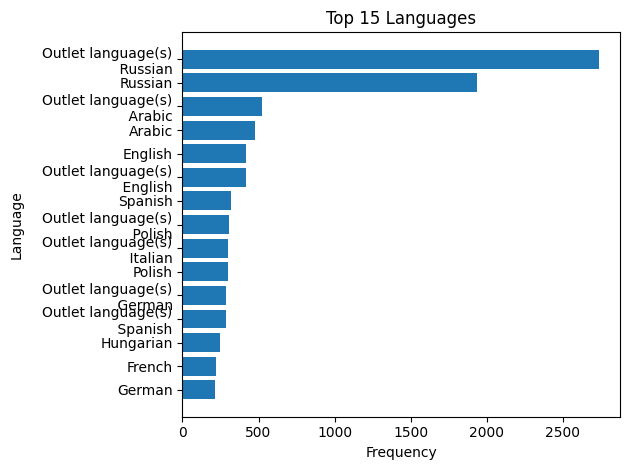

In [13]:
languages_counts = languages_df.value_counts().head(15)
languages_counts = languages_counts.iloc[::-1]
plt.barh(languages_counts.index, languages_counts.values)
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.title('Top 15 Languages')
plt.tight_layout()
plt.show()

Most of the articles are in Russian - 41%. German language is also popular

## 2. Doc2Vec

Doc2Vec is an extension of the Word2Vec model and is specifically designed for generating fixed-length vector representations (embeddings) for larger pieces of text, such as documents, paragraphs, or sentences. The main idea behind Doc2Vec is to capture the semantic meaning and contextual information of a piece of text by training a neural network to predict words in the context of a document. The training process involves learning vector representations for both words and documents simultaneously.

We will try Doc2Vec to work with corpus for semantic meaning.

In [14]:
#function for text preprocessing: case lower
def clean_document(doc):
    doc = doc.lower()
    return doc
#applying the preprocessing function to the column with fake news
data["Summary_norm"] = data.Summary.apply(clean_document)

In [15]:
#split dataset into train and test sets
train_data, test_data = train_test_split(data.Summary_norm, test_size=0.2, random_state=42)
len(train_data), len(test_data)

(7970, 1993)

7970 train instances, 1993 test instances

In [16]:
#tokenize the text using simple_preprocess and create TaggedDocuments
train_tagged_data = [TaggedDocument(words=simple_preprocess(text), tags=[i]) for i, text in enumerate(train_data)]
test_tagged_data = [gensim.utils.simple_preprocess(str(i[1])) for i in enumerate(test_data)]

In [17]:
# Train the Doc2Vec model
model = Doc2Vec(vector_size=512, epochs=10, seed=1, workers=1)
model.build_vocab(train_tagged_data)
model.train(train_tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [18]:
ranks = []
second_ranks = []
for doc_id in range(len(train_tagged_data)):
    inferred_vector = model.infer_vector(train_tagged_data[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [19]:
counter = collections.Counter(ranks)
print(counter)

Counter({0: 7499, 1: 135, 2: 56, 3: 28, 5: 24, 6: 16, 4: 16, 7: 14, 13: 10, 8: 8, 12: 6, 9: 6, 11: 6, 17: 5, 36: 4, 15: 4, 10: 4, 20: 3, 33: 3, 26: 3, 16: 3, 63: 3, 39: 3, 32: 2, 22: 2, 18: 2, 48: 2, 95: 2, 35: 2, 31: 2, 99: 2, 14: 2, 34: 2, 49: 2, 24: 2, 867: 1, 547: 1, 376: 1, 69: 1, 210: 1, 113: 1, 44: 1, 247: 1, 663: 1, 297: 1, 28: 1, 177: 1, 66: 1, 23: 1, 70: 1, 97: 1, 87: 1, 3112: 1, 383: 1, 195: 1, 166: 1, 80: 1, 75: 1, 620: 1, 473: 1, 3679: 1, 64: 1, 1194: 1, 3703: 1, 62: 1, 388: 1, 399: 1, 239: 1, 387: 1, 424: 1, 19: 1, 37: 1, 857: 1, 272: 1, 45: 1, 385: 1, 65: 1, 278: 1, 427: 1, 187: 1, 144: 1, 21: 1, 27: 1, 123: 1, 487: 1, 900: 1, 1251: 1, 25: 1, 140: 1, 381: 1, 52: 1, 42: 1, 149: 1, 1377: 1, 2179: 1, 207: 1, 191: 1, 554: 1, 211: 1, 320: 1, 2618: 1, 2181: 1, 435: 1, 3479: 1, 306: 1, 84: 1, 118: 1, 77: 1, 56: 1, 249: 1, 3652: 1, 286: 1, 246: 1, 256: 1, 264: 1, 165: 1, 879: 1, 38: 1, 397: 1, 3080: 1, 85: 1, 60: 1})


In [20]:
dis = data.Summary

In [21]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_tagged_data[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_tagged_data[sims[index][0]].words)))

Document (7969): «the western media ignores the fact that the usage of high dosage of vitamin saved lives in china the mainstream media in cahoots with governments and the medical establishment are suppressing any news regarding the use of cheap safe and easy to produce treatment for coronavirus patients maybe its because this treatment is being used in chinese hospitals to save lives as the global death toll soars higher we can only hope that more and more doctors will follow in the footsteps of their chinese colleagues and have the courage to use safe and cheap treatment that is totally at odds with the big pharma approach currently followed by the world health organisation and most governments the current approach used by many western governments has been slow clumsy and ill informed putting the interests of big business above saving the lives of ordinary people»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec<dm/m,d512,n5,w5,mc5,s0.001>:

MOST (7969, 0.8929998278617859): «the western me

Not surprisingly, the most similar text is the same text document. The second-most document has the same topic. The median and least similar documents are much sepparate from the initial text

In [22]:
# Pick a random document from the corpus and infer a vector from the model
doc_id = random.randint(0, len(train_tagged_data) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_tagged_data[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_tagged_data[sim_id[0]].words)))

Train Document (2750): «today ukraine is not only an anti russian but also an anti european project it is obvious the americans have much more instruments of influence on ukraine than europe has»

Similar Document (1775, 0.7736256718635559): «poland has difficult relations with the eu countries for poland it is important to have approval primarily from the united states it is no coincidence that military cooperation between poland and the united states intensified poland seeks to take the position that west germany took in europe during the cold war the position of the main us outpost in its aggressive policy towards russia»



Testing the Model

In [23]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_tagged_data) - 1)
inferred_vector = model.infer_vector(test_tagged_data[doc_id])
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_tagged_data[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_tagged_data[sims[index][0]].words)))

Test Document (267): «in kazakhstan similarly to ukraine belarus and georgia the west sponsored typical colour revolution for geopolitical purposes»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec<dm/m,d512,n5,w5,mc5,s0.001>:

MOST (13, 0.8071200847625732): «nato is deliberately worsening the situation in kosovo to blackmail serbia the west through nato countries is trying to exacerbate conflict between pristina and belgrade to benefit from the situation promoting chaos in the same way as before the maidan square coup this alert could be artificially fabricated by nato countries for serbia to change its political line towards what the west expects»

MEDIAN (6539, 0.38439974188804626): «we can see revision of history today as the european parliament passed resolution claiming that ussr is responsible for the start of wwii just like nazi germany however the nuremberg tribunal showed who was really responsible the lessons of nuremberg are forgotten because the us imagines itself to be the worl

Doc2Vec has been widely used in natural language processing (NLP) tasks where capturing the semantic meaning of larger text units is crucial. But Doc2Vec has several limitations, and Transformers models can address some of these shortcomings. Here are some disadvantages of Doc2Vec and how Transformers models offer solutions:

* 1) Lack of contextual information. Doc2Vec treats each document as a single fixed vector representation, disregarding the contextual information within the document. This limitation can affect the model's ability to capture fine-grained nuances and dependencies within the text. In contrast, Transformers models, such as BERT (Bidirectional Encoder Representations from Transformers), leverage self-attention mechanisms to capture contextual information at the word or subword level. This allows Transformers models to better understand the meaning and relationships within a document.

* 2) Limited vocabulary coverage: Doc2Vec relies on a pre-defined vocabulary, and out-of-vocabulary words are usually handled as unknown tokens. This limitation can be problematic for rare or domain-specific words that may not be adequately represented in the training data. Transformers models, on the other hand, employ subword tokenization, such as Byte-Pair Encoding (BPE), which can handle out-of-vocabulary words by breaking them down into subword units. This enables Transformers models to handle a much larger vocabulary and effectively represent rare or unseen words.

* 3) Lack of transparency and interpretability: Doc2Vec provides vector embeddings for documents, but it can be challenging to interpret the underlying factors contributing to the embeddings. Transformers models, particularly those with attention mechanisms, offer more interpretability by providing attention weights that indicate the importance of different parts of the input text. These attention weights can help understand which words or phrases contribute more to the model's predictions.

* 4) Difficulty in updating embeddings: Once trained, Doc2Vec embeddings are typically static and cannot be easily updated with new data. Transformers models, however, can be fine-tuned on new data to adapt the embeddings to specific domains or tasks. This flexibility allows Transformers models to continually learn from new information and improve their representations.

Overall, while Doc2Vec has its limitations, Transformers models address some of these drawbacks by incorporating contextual information, handling out-of-vocabulary words, leveraging large-scale pre-training, providing interpretability, and allowing for fine-tuning on specific tasks. These advantages make Transformers models a powerful choice for various NLP applications.

## 3. Tranformers


The Roberta transformer model offers several advantages for text classification tasks, including fake news recognition. Some of the pros of using the Roberta transformer model are:

Pre-trained Language Representation: The Roberta model is pre-trained on a massive amount of text data, including a vast range of domains and languages. This pre-training allows the model to capture rich semantic and contextual information, enabling it to understand complex language patterns and nuances.

Transformer Architecture: The Roberta model is based on the Transformer architecture, which incorporates self-attention mechanisms. This architecture allows the model to consider the relationships between all words in a sentence, capturing long-range dependencies and improving its ability to understand the context.

Large Model Size: The Roberta model is trained on a large-scale dataset and has a large number of parameters, making it capable of capturing fine-grained details in text. This enables the model to learn more intricate patterns and representations, enhancing its performance in various text classification tasks.

Transfer Learning: Due to its pre-training, the Roberta model can be fine-tuned on specific downstream tasks, such as fake news recognition. Fine-tuning involves training the model on a smaller, task-specific dataset to adapt it to the specific classification task at hand. Transfer learning with the Roberta model allows for quicker convergence and better performance, especially when labeled data for the specific task is limited.

State-of-the-Art Performance: The Roberta model has achieved state-of-the-art performance on various natural language processing benchmarks and competitions. It has demonstrated excellent results in tasks like sentiment analysis, named entity recognition, and text classification. Its strong performance makes it a reliable choice for fake news recognition, where accurate classification is crucial.

Multilingual Support: The Roberta model can handle multiple languages effectively. It has been trained on diverse language sources, enabling it to understand and classify text in different languages. This flexibility is particularly advantageous for fake news detection, as disinformation can originate from various regions and in multiple languages.

Overall, the Roberta transformer model's pre-training, transformer architecture, large model size, transfer learning capabilities, state-of-the-art performance, and multilingual support make it a powerful choice for text classification tasks, including fake news recognition.

#### Creating a dataset

Now we will create a `fake` dataframe with column of fake news and a column `True` indicating the label of the news: `0` - fake news, `1` - true news.

For now we will use only a part of the initial dataset with 4000 rows of fake news

In [24]:
fake = pd.DataFrame(data['Summary'])
fake['True'] = 0
fake = fake.sample(frac=1, random_state=42).reset_index(drop=True)[:4000]
print(fake.shape)
fake.head()

(4000, 2)


,Summary,True
0,"Since last autumn, the Ukrainian Orthodox Chur...",0
1,Vilnius wants to be the centre for the Belarus...,0
2,The special military operation opened the way ...,0
3,Ukraine is already waste material for the West...,0
4,Crimea became a Russian region after a referen...,0


Same with true news: -separate dataframe; - column with label; - rename the column for future concatenation; - sample only 4000 rows

In [25]:
true = pd.DataFrame(data['Disproof'])
true['True'] = 1
true=true.rename(columns={'Disproof': 'Summary'})
true = true.sample(frac=1, random_state=42).reset_index(drop=True)[:4000]
print(true.shape)
true.head()

(4000, 2)


,Summary,True
0,Recurring pro-Kremlin disinformation narrative...,1
1,This is an attempt to portray Lithuania as a p...,1
2,This is a disinformation narrative from pro-Kr...,1
3,Disinformation amid Russia's full-scale invasi...,1
4,Recurring pro-Kremlin disinformation narrative...,1


Concatenating the two dataframes with fake and true news into one and shuffle them

In [26]:
concatenated = pd.concat([fake, true], ignore_index=True)
concatenated = concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
print(concatenated.shape)

(8000, 2)


Now we have a dataset with 8000 rows of news: half of them are `fake` (label 0) and half `true` (label 1)

In [27]:
concatenated.head()

,Summary,True
0,There are three rationales behind the story ab...,0
1,The WHO concluded that the agent responsible f...,0
2,The European Endowment for Democracy has grown...,0
3,Regular flights will be launched between Crime...,0
4,"Conspiracy theory, recurring pro-Kremlin narra...",1


#### Selecting and fine-tuning the model

The Model Hub makes selecting the appropriate model simple. I looked up a text classification transformer that could perform fake news detection. I select pretrained `jy46604790/Fake-News-Bert-Detect` (Roberta model trained by over 40,000 news from different medias based on the 'roberta-base')  checkpoint for future fine-tuning

Initialize a model for sequence classification using the Roberta architecture:

In [28]:
checkpoint = 'jy46604790/Fake-News-Bert-Detect' #https://huggingface.co/jy46604790/Fake-News-Bert-Detect
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = RobertaForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    id2label={0: "FAKE", 1: "TRUE"}, #set up the mappings between class labels and their numerical representations
    label2id={"FAKE": 0, "TRUE": 1}
)

#### Architecture of the model:

In [29]:
print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

The model has almost 125 millions of trainable parameters in the model, including the weights and biases of all the layers and submodules.

The architecture of the RobertaForSequenceClassification model and its submodules:

* RobertaForSequenceClassification: the main model class that encapsulates the entire architecture for sequence classification using the Roberta model.

* (roberta): RobertaModel: the Roberta model component of the RobertaForSequenceClassification. It consists of several submodules:

--(embeddings): RobertaEmbeddings: submodule handles the input embeddings for the Roberta model. It includes word embeddings, position embeddings, token type embeddings, layer normalization, and dropout.

--(encoder): RobertaEncoder: submodule represents the encoder part of the Roberta model. It contains a stack of 12 layers (0-11), each represented by the RobertaLayer submodule.

 --- RobertaLayer: submodule represents a single layer in the Roberta model. Each layer consists of the following submodules:

  ---- RobertaAttention: submodule handles the self-attention mechanism within a layer, including query, key, and value linear transformations, dropout, and layer normalization.

  ---- RobertaIntermediate: submodule performs an intermediate transformation after the attention mechanism. It includes a dense linear layer and a GELU activation function.

  ---- RobertaOutput: submodule represents the output transformation after the intermediate layer. It includes a dense linear layer, layer normalization, and dropout.

--(classifier): RobertaClassificationHead: submodule is responsible for the classification task. It consists of the following submodules:
* dense: A dense linear layer for feature transformation.
* dropout: Dropout regularization.
* out_proj: A final linear layer for mapping the features to the output class labels (2 classes in this case).

In [30]:
model = model.to('cuda') #to gpu

#### Split the train/test dataset and Tokenize

Roberta Tokenizer:

- splits the text into tokens (words and subwords) representing each token with its corresponding id
- special tokens are added, e.g. to mark the beginning of an input text `[CLS]`
- `token_type_ids` are always 0 in our case. In pretraining and other downstream tasks these IDs are used to distinguish a first from a second segment.
- transforms the input data to a consistent length of 512 tokens. If the input text is shorter than 512 tokens, it is filled up with 0 tokens (padding). If the text is longer than 512 tokens than part of the text is truncated.
- creates an `attention_mask` that marks with 0 if the tokens result from padding and 1 otherwise.

In [31]:
X = list(concatenated["Summary"])
y = list(concatenated["True"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y) #20%- test dataset
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [32]:
print(X_train[0]),
print(y_train[0])

Russian authorities are concerned about the US biological-military activity near Russia’s borders. There are over 200 secret research laboratories in the world mostly funded by the US Department of Defence, focusing on doubtful investigations, the Richard Lugar Centre in Georgia is one of the most notorious. Russia has more than on one occasion drawn attention to Pentagon’s activities, which deploys its laboratories in the vicinity of Russian borders.
0


In [33]:
len(X_train),len(X_val)

(6400, 1600)

6400 instances for training, and 1600 instances for testing

#### Create torch dataset class

A torch dataset class must implement the methods init, getitem and len

In [34]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [35]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

#### Evaluation metrics

We define a function that computes evaluation metrics: accuracy, recall, precision, f1

In [36]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#### Configurations for training and validation

Set up the training and evaluation configurations for a model using the Hugging Face `Trainer` and `TrainingArguments` classes.

`TrainingArguments` class is used to define the training arguments and hyperparameters. `Trainer` class is responsible for training and evaluation loops.

In [37]:
args = TrainingArguments(
    output_dir="Roberta-fake-news-detector", #the directory where the results and trained model checkpoints will be stored
    num_train_epochs=5, #the maximum number of training epochs
    per_device_train_batch_size=4, #the batch size for training data
    per_device_eval_batch_size=4, #the batch size for evaluation/validation data
    logging_strategy = 'epoch', #the logging strategy for training metrics - at the end of each epoch
    evaluation_strategy = "epoch", #when to evaluate the validation data performance -  after each epoch
    save_strategy = "epoch", #when to save the model checkpoints - after each epoch.
    save_total_limit = 3, #the limit for the number of saved model checkpoints - only the last three checkpoints will be saved.
    learning_rate=2e-5, #the learning rate for the optimizer during training
    weight_decay=0.01, # the L2 regularization parameter to reduce overfitting
    warmup_ratio=0.1, #the ratio of steps for the learning rate warm-up during the initial training phase - 10%
    load_best_model_at_end=True, #whether to load the best model checkpoint based on the chosen metric (f1 in this case) at the end of training.
    metric_for_best_model="f1", #the metric to determine the "best" model checkpoint during training
    push_to_hub=False #the model is already on HuggingFace Hub: https://huggingface.co/winterForestStump/Roberta-fake-news-detector
)

trainer = Trainer(
    model=model, #the pre-configured model to be trained
    args=args, #TrainingArguments object that defines the training configurations
    train_dataset=train_dataset, #training dataset used for model training
    eval_dataset=val_dataset, #evaluation/validation dataset used for performance evaluation
    tokenizer=tokenizer, #tokenizer associated with the model for proper tokenization of the input data
    compute_metrics=compute_metrics, #function that computes the evaluation metrics for the model's predictions
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] #If the F1-metric does not improve during 3 evaluation runs, then model stops
)

#### Training

In [38]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.241700,0.042779,0.993750,0.997481,0.990000,0.993726
2,0.038400,0.037745,0.995000,0.992537,0.997500,0.995012
3,0.012000,0.035154,0.994375,0.993758,0.995000,0.994379
4,0.007900,0.033000,0.996250,0.996250,0.996250,0.996250
5,0.001700,0.033917,0.996250,0.996250,0.996250,0.996250


TrainOutput(global_step=8000, training_loss=0.06033633586764336, metrics={'train_runtime': 3559.2825, 'train_samples_per_second': 8.991, 'train_steps_per_second': 2.248, 'total_flos': 8419553771520000.0, 'train_loss': 0.06033633586764336, 'epoch': 5.0})

* The training loss decreases significantly with each epoch, indicating that the model is learning and improving its predictions.

* The validation loss also decreases initially but slightly increases in the later epochs. This suggests that the model may be starting to overfit the training data.

* The accuracy of the model on the validation dataset is consistently high. This indicates that the model performs well in classifying fake and true news.

* The precision of the model is high, indicating that when the model predicts a news article as fake or true, it is highly confident in its predictions.

* The recall values are also high, suggesting that the model is able to identify a high percentage of the actual fake and true news articles in the dataset.

* The F1 score, which balances precision and recall, is consistently high. This indicates that the model achieves a good trade-off between precision and recall.

* The training process took approximately 1 hour to complete all 5 epochs.

The training results indicate that the model successfully learns to classify fake and true news with high accuracy, precision, recall, and F1 score. However, there is a slight increase in validation loss towards the later epochs, suggesting potential overfitting. Monitoring the model's performance on unseen data and considering early stopping can help prevent overfitting and improve generalization capabilities.

#### Evaluating

In [39]:
trainer.evaluate()

{'eval_loss': 0.03299999609589577,
 'eval_accuracy': 0.99625,
 'eval_precision': 0.99625,
 'eval_recall': 0.99625,
 'eval_f1': 0.99625,
 'eval_runtime': 52.3627,
 'eval_samples_per_second': 30.556,
 'eval_steps_per_second': 7.639,
 'epoch': 5.0}

* The evaluation loss is low - the model performs well on the unseen validation data. It suggests that the model can generalize and make accurate predictions on new instances.

* The evaluation accuracy is high -  the model correctly classifies 99% of the news articles as fake or true. This indicates a high level of overall accuracy.

* The precision of the model is 99%, implying that when the model predicts a news article as fake or true, it is highly likely to be correct.

* The recall is 99%, indicating that the model can identify a high percentage of the actual fake and true news articles in the evaluation dataset.

* The F1 score, which balances precision and recall, is 99%. This score indicates that the model achieves a good trade-off between precision and recall on the evaluation data.

* The evaluation process took approximately 50 seconds to evaluate the model on the evaluation dataset.

The evaluation results demonstrate that the model performs exceptionally well on the unseen evaluation dataset. It achieves high accuracy, precision, recall, and F1 score, indicating its effectiveness in classifying fake and true news. The evaluation metrics suggest that the model generalizes well and can make reliable predictions on new data.

#### Testing the model to predict the news:

Example 1 (fake news):

In [40]:
text = "Zelenskyy is a puppet, Russia will only negotiate with his masters directly"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
print(predictions)
print(np.argmax(predictions))

SequenceClassifierOutput(loss=None, logits=tensor([[ 5.3953, -5.9533]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[9.9999e-01, 1.1787e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[[9.9998820e-01 1.1786609e-05]]
0


Example 2 (fake news):

In [41]:
text = "From the very beginning, the EU has been extremely non-transparent. The deployment of the European Union presence in Armenia was carried out forcefully, under serious pressure from Brussels"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
print(predictions)
print(np.argmax(predictions))

SequenceClassifierOutput(loss=None, logits=tensor([[ 5.4174, -5.9811]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[9.9999e-01, 1.1212e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[[9.9998879e-01 1.1212225e-05]]
0


Example 3 (true news):

In [42]:
text = "Pro-Kremlin disinformation narrative about Russia as the ultimate target of international events, accusing the West of having an anti-Russian agenda in the Caucasus and CIS countries. "
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
print(predictions)
print(np.argmax(predictions))

SequenceClassifierOutput(loss=None, logits=tensor([[-5.8374,  6.3219]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[5.2397e-06, 9.9999e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[[5.2396522e-06 9.9999475e-01]]
1


#### Check the model from Hugging Face Hub:

The ready model is in the HuggingFace Hub: https://huggingface.co/winterForestStump/Roberta-fake-news-detector.

We can download the model and check the performance on the same example texts:

In [53]:
%%capture
!pip install xformers

In [54]:
from transformers import pipeline
MODEL = "winterForestStump/Roberta-fake-news-detector"
clf = pipeline("text-classification", model=MODEL, tokenizer=MODEL)

Example 1 (fake news):

In [44]:
text = "Zelenskyy is a puppet, Russia will only negotiate with his masters directly"
result = clf(text)
result

[{'label': 'FAKE', 'score': 0.9999945163726807}]

Example 2 (fake news):

In [45]:
text = "From the very beginning, the EU has been extremely non-transparent. The deployment of the European Union presence in Armenia was carried out forcefully, under serious pressure from Brussels"
result = clf(text)
result

[{'label': 'FAKE', 'score': 0.9999946355819702}]

Example 3 (true news):

In [46]:
text = "Pro-Kremlin disinformation narrative about Russia as the ultimate target of international events, accusing the West of having an anti-Russian agenda in the Caucasus and CIS countries. "
result = clf(text)
result

[{'label': 'TRUE', 'score': 0.9999948740005493}]

We can see that the model works well and gives the same results as the one we trained on this notebook

## Transformers Interpret

Transformers Interpret is a model explainability tool designed to work exclusively with the 🤗 transformers package.

In [47]:
%%capture
!pip install transformers-interpret

Sequence Classification Explainer and Pairwise Sequence Classification
Let's start by initializing a transformers' model and tokenizer, and running it through the `SequenceClassificationExplainer`.

For this example we are using our model:

In [48]:
from transformers_interpret import SequenceClassificationExplainer
model_name = "winterForestStump/Roberta-fake-news-detector"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [49]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)
word_attributions = cls_explainer("From the very beginning, the EU has been extremely non-transparent. The deployment of the European Union presence in Armenia was carried out forcefully, under serious pressure from Brussels")

Which will return the following list of tuples:

In [50]:
word_attributions

[('<s>', 0.0),
 ('From', -0.14752987798764464),
 ('the', 0.21637903759495786),
 ('very', -0.11274144771068481),
 ('beginning', 0.25211618073725345),
 (',', 0.21669941659000122),
 ('the', 0.17578234503724585),
 ('EU', 0.05461864456863608),
 ('has', 0.19530022232497907),
 ('been', 0.09889076848470149),
 ('extremely', 0.01478450970238453),
 ('non', -0.08307803952801526),
 ('-', 0.07926966630987065),
 ('trans', -0.27112688466535695),
 ('parent', 0.026650512179005194),
 ('.', -0.2854688496681734),
 ('The', -0.29729131447744256),
 ('deployment', -0.166791198949026),
 ('of', 0.10615873428034038),
 ('the', -0.01017076965683838),
 ('European', 0.08651183088971146),
 ('Union', 0.22008352652602584),
 ('presence', 0.16571533879537798),
 ('in', -0.2795114899867428),
 ('Armenia', 0.11665587689946937),
 ('was', 0.05192535621947109),
 ('carried', 0.13140400553647455),
 ('out', 0.08540513741471278),
 ('forcefully', -0.12135045560861883),
 (',', -0.06002484442895135),
 ('under', -0.09456843635293177),
 

Positive attribution numbers indicate a word contributes positively towards the predicted class, while negative numbers indicate a word contributes negatively towards the predicted class.

We can use `predicted_class_index` in case we'd want to know what the predicted class actually is and if the model has label names for each class, we can see these too using `predicted_class_name`:

In [51]:
print(cls_explainer.predicted_class_index)
print(cls_explainer.predicted_class_name)

0
FAKE


Sometimes the numeric attributions can be difficult to read particularly in instances where there is a lot of text. To help with that we also provide the visualize() method that utilizes Captum's in built viz library to create a HTML file highlighting the attributions.

In [52]:
cls_explainer.visualize("roberta_viz.html")

## Future work:

* We only cover a part of the database (around 40%). Next step could be train the model on the whole dataset
* Fine-tune training hyperparameters (number the epochs, batch size) for better performance
* Try different pretrained transformer models from HuggingFace Hub
* The model is based on data from the EUvsDisinfo project Database. Therefore, if there is an error in the database, the model inherits that error. It is impossible to exclude this risk completely although the project has a high reputation and is supported by the European Union.
* The model makes decisions based on historical data and does not take into account recent events. To maintain relevance, the model should be trained on newly released database updates.